In [36]:
# =========================
# 1. KẾT NỐI GOOGLE DRIVE
# =========================
from google.colab import drive

# Kết nối với Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [37]:
import zipfile
import os

# Đường dẫn tới file zip trong Google Drive
zip_path = '/content/drive/MyDrive/datasets/archive.zip'

# Thư mục giải nén ra
extract_path = '/content/FER_CNN_LSTM/dataset'

# Tạo thư mục nếu chưa có
os.makedirs(extract_path, exist_ok=True)

# Giải nén
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(" Giải nén hoàn tất! Kiểm tra thư mục:", extract_path)


 Giải nén hoàn tất! Kiểm tra thư mục: /content/FER_CNN_LSTM/dataset


In [38]:
import os
from collections import defaultdict

def count_images_by_class(folder_path):
    class_counts = defaultdict(int)
    total_images = 0

    for class_name in sorted(os.listdir(folder_path)):
        class_folder = os.path.join(folder_path, class_name)
        if os.path.isdir(class_folder):
            num_images = len([
                f for f in os.listdir(class_folder)
                if f.lower().endswith(('.jpg', '.png', '.jpeg'))
            ])
            class_counts[class_name] = num_images
            total_images += num_images

    return total_images, class_counts

# Đường dẫn đến thư mục chứa các thư mục cảm xúc
dataset_path = '/content/FER_CNN_LSTM/dataset'

# Đếm và in kết quả
total_images, emotion_counts = count_images_by_class(dataset_path)

print(f"\n Tổng số ảnh trong bộ CK+: {total_images}")
for emotion, count in emotion_counts.items():
    print(f" - {emotion}: {count} ảnh")



 Tổng số ảnh trong bộ CK+: 981
 - anger: 135 ảnh
 - contempt: 54 ảnh
 - disgust: 177 ảnh
 - fear: 75 ảnh
 - happy: 207 ảnh
 - sadness: 84 ảnh
 - surprise: 249 ảnh


In [39]:
# =========================
# 2. CÀI ĐẶT THƯ VIỆN
# =========================
!pip install tensorflow opencv-python matplotlib seaborn

In [41]:
# =========================
# 3. IMPORT THƯ VIỆN (THUẦN KERAS)
# =========================
import os
import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

# Dùng KERAS gốc
from keras.models import Sequential
from keras.layers import (
    Conv2D, MaxPooling2D, Dropout, Flatten, Dense,
    LSTM, TimeDistributed, BatchNormalization, Input
)
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint


In [42]:
import os
import glob
import numpy as np
import cv2
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# =========================
# 4. CẤU HÌNH BAN ĐẦU
# =========================
IMG_SIZE = 48
NUM_CLASSES = 7
NUM_FRAMES = 3
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 1)
SEQ_SHAPE = (NUM_FRAMES, IMG_SIZE, IMG_SIZE, 1)
BATCH_SIZE = 64
EPOCHS = 120
LEARNING_RATE = 0.001

# =========================
# 5. LOAD DỮ LIỆU
# =========================
def load_ckplus_data(data_path, img_size=48):
    images = []
    labels = []
    label_names = sorted(os.listdir(data_path))

    for label in label_names:
        class_path = os.path.join(data_path, label)
        if not os.path.isdir(class_path):
            continue
        img_files = glob.glob(os.path.join(class_path, '*.jpg')) + glob.glob(os.path.join(class_path, '*.png'))
        for file in img_files:
            img = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (img_size, img_size))
            img = img.astype('float32') / 255.0
            images.append(img)
            labels.append(label)

    return np.array(images), np.array(labels)

# =========================
# GỌI HÀM LOAD DỮ LIỆU
# =========================
dataset_path = '/content/FER_CNN_LSTM/dataset'
X_all, y_all = load_ckplus_data(dataset_path, img_size=IMG_SIZE)

# =========================
# MÃ HÓA NHÃN (LabelEncoder + One-hot)
# =========================
label_encoder = LabelEncoder()
y_all_encoded = label_encoder.fit_transform(y_all)
NUM_CLASSES = len(label_encoder.classes_)  # Cập nhật lại nếu số nhãn khác 7

y_all_cat = to_categorical(y_all_encoded, num_classes=NUM_CLASSES)

# =========================
# THÊM KÊNH MÀU CHO ẢNH
# =========================
X_all = np.expand_dims(X_all, axis=-1)  # (samples, 48, 48, 1)

# =========================
# CHIA TRAIN/TEST 80:20
# =========================
X_train, X_test, y_train_cat, y_test_cat = train_test_split(
    X_all, y_all_cat, test_size=0.2, random_state=42, stratify=y_all_encoded
)

# =========================
# CHUYỂN THÀNH CHUỖI CHO LSTM
# =========================
def reshape_to_sequence(X, y, num_frames, img_size, num_classes):
    n = (X.shape[0] // num_frames) * num_frames
    X = X[:n]
    y = y[:n]
    X_seq = X.reshape((-1, num_frames, img_size, img_size, 1))
    y_seq = y.reshape((-1, num_frames, num_classes))
    y_seq_last = y_seq[:, -1, :]  # lấy nhãn của frame cuối
    return X_seq, y_seq_last

X_train_seq, y_train_seq = reshape_to_sequence(X_train, y_train_cat, NUM_FRAMES, IMG_SIZE, NUM_CLASSES)
X_test_seq,  y_test_seq  = reshape_to_sequence(X_test, y_test_cat, NUM_FRAMES, IMG_SIZE, NUM_CLASSES)


In [43]:
# =========================
# 6. XÂY DỰNG MÔ HÌNH CNN-LSTM
# =========================

from keras.models import Sequential
from keras.layers import (
    Conv2D, MaxPooling2D, Dropout, Flatten, Dense,
    LSTM, TimeDistributed, BatchNormalization
)
from keras.optimizers import Adam

# Khởi tạo mô hình tuần tự (Sequential)
model = Sequential()

# ----- BLOCK CNN 1 -----
model.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu'),
                          input_shape=(NUM_FRAMES, IMG_SIZE, IMG_SIZE, 1)))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(Dropout(0.3)))

# ----- BLOCK CNN 2 -----
model.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(Flatten()))

# ----- LSTM -----
model.add(LSTM(128))
model.add(Dropout(0.5))

# ----- FULLY CONNECTED (Output) -----
model.add(Dense(NUM_CLASSES, activation='softmax'))

# ----- BIÊN DỊCH MÔ HÌNH -----
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# In cấu trúc mô hình
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_24             │ (None, 3, 46, 46, 32)  │           320 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_25             │ (None, 3, 23, 23, 32)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_26             │ (None, 3, 23, 23, 32)  │           128 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_27             │ (None, 3, 23, 23, 32)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_28             │ (None, 3, 21, 21, 64)  │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_29             │ (None, 3, 10, 10, 64)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_30             │ (None, 3, 10, 10, 64)  │           256 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_31             │ (None, 3, 6400)        │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 128)            │     3,342,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,362,951 (12.83 MB)

 Trainable params: 3,362,759 (12.83 MB)

 Non-trainable params: 192 (768.00 B)

In [44]:
# =========================
# 7. CHUẨN HÓA DỮ LIỆU ĐẦU VÀO DẠNG CHUỖI
# =========================

def reshape_to_sequence(X, y, num_frames):
    """
    Cắt dữ liệu để đảm bảo chia hết cho num_frames,
    sau đó reshape thành dạng chuỗi cho mô hình CNN-LSTM.
    """
    n = (X.shape[0] // num_frames) * num_frames  # Cắt bớt ảnh dư
    X = X[:n]
    y = y[:n]

    # Reshape ảnh thành chuỗi: (số chuỗi, num_frames, 48, 48, 1)
    X_seq = X.reshape((-1, num_frames, IMG_SIZE, IMG_SIZE, 1))

    # Reshape nhãn và lấy nhãn cuối mỗi chuỗi làm đại diện
    y_seq = y.reshape((-1, num_frames, NUM_CLASSES))
    y_seq_last = y_seq[:, -1, :]  # lấy nhãn frame cuối làm nhãn đại diện

    return X_seq, y_seq_last

# Gọi hàm chuẩn hóa chuỗi
X_train_seq, y_train_seq = reshape_to_sequence(X_train, y_train_cat, NUM_FRAMES)
X_test_seq,  y_test_seq  = reshape_to_sequence(X_test, y_test_cat, NUM_FRAMES)

# In kiểm tra shape kết quả
print("X_train_seq shape:", X_train_seq.shape)
print("y_train_seq shape:", y_train_seq.shape)


X_train_seq shape: (261, 3, 48, 48, 1)
y_train_seq shape: (261, 7)


In [46]:
from keras.callbacks import Callback
import os

# Tạo callback tùy chỉnh để lưu mỗi 5 epoch
class SaveEveryNEpochs(Callback):
    def __init__(self, save_path, period=5):
        super().__init__()
        self.save_path = save_path
        self.period = period

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.period == 0:
            filename = os.path.join(self.save_path, f'model_epoch_{epoch + 1:02d}.h5')
            self.model.save(filename)
            print(f'\nSaved model to {filename}')

# Đường dẫn lưu
checkpoint_dir = '/content/drive/MyDrive/FER_CNN_LSTM/checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)
save_callback = SaveEveryNEpochs(checkpoint_dir, period=5)

# Huấn luyện
history = model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_test_seq, y_test_seq),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[save_callback],
    verbose=1
)


Epoch 1/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 211ms/step - accuracy: 0.2674 - loss: 2.1331 - val_accuracy: 0.2000 - val_loss: 1.9022
Epoch 2/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.4326 - loss: 1.5796 - val_accuracy: 0.1077 - val_loss: 2.0095
Epoch 3/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.6381 - loss: 1.3078 - val_accuracy: 0.1077 - val_loss: 2.3559
Epoch 4/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.6475 - loss: 1.0995 - val_accuracy: 0.1077 - val_loss: 2.7002
Epoch 5/120
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.7122 - loss: 0.9276


Saved model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_05.h5
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 507ms/step - accuracy: 0.7162 - loss: 0.9375 - val_accuracy: 0.1077 - val_loss: 3.0035
Epoch 6/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.7413 - loss: 0.8686 - val_accuracy: 0.1077 - val_loss: 3.1754
Epoch 7/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.7961 - loss: 0.7183 - val_accuracy: 0.1077 - val_loss: 3.0460
Epoch 8/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.8058 - loss: 0.6693 - val_accuracy: 0.1077 - val_loss: 3.0222
Epoch 9/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8081 - loss: 0.6966 - val_accuracy: 0.1077 - val_loss: 3.1199
Epoch 10/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8859 - loss: 0.5381


Saved model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_10.h5
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 542ms/step - accuracy: 0.8832 - loss: 0.5404 - val_accuracy: 0.1077 - val_loss: 3.1388
Epoch 11/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.8842 - loss: 0.4987 - val_accuracy: 0.1077 - val_loss: 3.2191
Epoch 12/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.8734 - loss: 0.4833 - val_accuracy: 0.1077 - val_loss: 3.3440
Epoch 13/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9300 - loss: 0.4250 - val_accuracy: 0.1077 - val_loss: 3.4477
Epoch 14/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.8901 - loss: 0.4800 - val_accuracy: 0.1077 - val_loss: 3.2846
Epoch 15/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8957 - loss: 0.4545


Saved model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_15.h5
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 499ms/step - accuracy: 0.8977 - loss: 0.4498 - val_accuracy: 0.1077 - val_loss: 3.2222
Epoch 16/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.9189 - loss: 0.4063 - val_accuracy: 0.1077 - val_loss: 3.1839
Epoch 17/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9446 - loss: 0.3280 - val_accuracy: 0.1077 - val_loss: 3.3124
Epoch 18/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9521 - loss: 0.3014 - val_accuracy: 0.1077 - val_loss: 3.4356
Epoch 19/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9523 - loss: 0.2686 - val_accuracy: 0.1077 - val_loss: 3.4869
Epoch 20/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9650 - loss: 0.2294


Saved model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_20.h5
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.9644 - loss: 0.2314 - val_accuracy: 0.1077 - val_loss: 3.4917
Epoch 21/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.9825 - loss: 0.2137 - val_accuracy: 0.1077 - val_loss: 3.4805
Epoch 22/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9737 - loss: 0.1812 - val_accuracy: 0.1077 - val_loss: 3.5503
Epoch 23/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9817 - loss: 0.2049 - val_accuracy: 0.1077 - val_loss: 3.6526
Epoch 24/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 0.9940 - loss: 0.1701 - val_accuracy: 0.1077 - val_loss: 3.6839
Epoch 25/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9902 - loss: 0.1654


Saved model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_25.h5
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.9892 - loss: 0.1676 - val_accuracy: 0.1077 - val_loss: 3.6002
Epoch 26/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.9968 - loss: 0.1399 - val_accuracy: 0.1077 - val_loss: 3.5009
Epoch 27/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.9906 - loss: 0.1372 - val_accuracy: 0.1077 - val_loss: 3.4320
Epoch 28/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.9812 - loss: 0.1608 - val_accuracy: 0.1077 - val_loss: 3.3411
Epoch 29/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9914 - loss: 0.1359 - val_accuracy: 0.1077 - val_loss: 3.2551
Epoch 30/120
3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9809 - loss: 0.1343


Saved model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_30.h5
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 437ms/step - accuracy: 0.9827 - loss: 0.1427 - val_accuracy: 0.1077 - val_loss: 3.1376
Epoch 31/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9961 - loss: 0.1289 - val_accuracy: 0.1077 - val_loss: 3.1550
Epoch 32/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9981 - loss: 0.0907 - val_accuracy: 0.1077 - val_loss: 3.0972
Epoch 33/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9972 - loss: 0.0923 - val_accuracy: 0.1077 - val_loss: 3.0522
Epoch 34/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 1.0000 - loss: 0.0925 - val_accuracy: 0.1077 - val_loss: 2.8716
Epoch 35/120
3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9905 - loss: 0.0936


Saved model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_35.h5
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 438ms/step - accuracy: 0.9933 - loss: 0.0909 - val_accuracy: 0.1231 - val_loss: 2.6171
Epoch 36/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.9981 - loss: 0.0785 - val_accuracy: 0.1385 - val_loss: 2.3729
Epoch 37/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 1.0000 - loss: 0.0738 - val_accuracy: 0.1692 - val_loss: 2.1148
Epoch 38/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9959 - loss: 0.0820 - val_accuracy: 0.2462 - val_loss: 1.8562
Epoch 39/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9914 - loss: 0.0910 - val_accuracy: 0.4462 - val_loss: 1.5169
Epoch 40/120
3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9905 - loss: 0.0814


Saved model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_40.h5
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.9933 - loss: 0.0776 - val_accuracy: 0.5538 - val_loss: 1.1218
Epoch 41/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.9933 - loss: 0.0750 - val_accuracy: 0.6923 - val_loss: 0.8596
Epoch 42/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9931 - loss: 0.0809 - val_accuracy: 0.7385 - val_loss: 0.7273
Epoch 43/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 1.0000 - loss: 0.0657 - val_accuracy: 0.7692 - val_loss: 0.6550
Epoch 44/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 1.0000 - loss: 0.0622 - val_accuracy: 0.8000 - val_loss: 0.6395
Epoch 45/120
3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 1.0000 - loss: 0.0500


Saved model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_45.h5
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 543ms/step - accuracy: 1.0000 - loss: 0.0537 - val_accuracy: 0.7846 - val_loss: 0.6675
Epoch 46/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 1.0000 - loss: 0.0490 - val_accuracy: 0.8154 - val_loss: 0.5855
Epoch 47/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 1.0000 - loss: 0.0470 - val_accuracy: 0.8462 - val_loss: 0.4332
Epoch 48/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 1.0000 - loss: 0.0610 - val_accuracy: 0.8615 - val_loss: 0.3980
Epoch 49/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9933 - loss: 0.0536 - val_accuracy: 0.8615 - val_loss: 0.3961
Epoch 50/120
3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 1.0000 - loss: 0.0439


Saved model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_50.h5
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 463ms/step - accuracy: 1.0000 - loss: 0.0449 - val_accuracy: 0.8615 - val_loss: 0.3783
Epoch 51/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 1.0000 - loss: 0.0523 - val_accuracy: 0.8615 - val_loss: 0.3423
Epoch 52/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9933 - loss: 0.0554 - val_accuracy: 0.8923 - val_loss: 0.2805
Epoch 53/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9981 - loss: 0.0371 - val_accuracy: 0.8923 - val_loss: 0.2648
Epoch 54/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 1.0000 - loss: 0.0475 - val_accuracy: 0.8923 - val_loss: 0.2533
Epoch 55/120
3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 1.0000 - loss: 0.0302


Saved model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_55.h5
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 464ms/step - accuracy: 1.0000 - loss: 0.0309 - val_accuracy: 0.9231 - val_loss: 0.2410
Epoch 56/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 1.0000 - loss: 0.0351 - val_accuracy: 0.9231 - val_loss: 0.2184
Epoch 57/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 1.0000 - loss: 0.0339 - val_accuracy: 0.9231 - val_loss: 0.1922
Epoch 58/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 0.0298 - val_accuracy: 0.9385 - val_loss: 0.1874
Epoch 59/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 1.0000 - loss: 0.0347 - val_accuracy: 0.9231 - val_loss: 0.2023
Epoch 60/120
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 1.0000 - loss: 0.0299


Saved model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_60.h5
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 606ms/step - accuracy: 1.0000 - loss: 0.0302 - val_accuracy: 0.9077 - val_loss: 0.2134
Epoch 61/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 1.0000 - loss: 0.0309 - val_accuracy: 0.9385 - val_loss: 0.1946
Epoch 62/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 1.0000 - loss: 0.0265 - val_accuracy: 0.9538 - val_loss: 0.1644
Epoch 63/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 1.0000 - loss: 0.0273 - val_accuracy: 0.9538 - val_loss: 0.1502
Epoch 64/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 0.0265 - val_accuracy: 0.9385 - val_loss: 0.1594
Epoch 65/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 1.0000 - loss: 0.0286


Saved model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_65.h5
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 789ms/step - accuracy: 1.0000 - loss: 0.0289 - val_accuracy: 0.9385 - val_loss: 0.1740
Epoch 66/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 1.0000 - loss: 0.0267 - val_accuracy: 0.9538 - val_loss: 0.1902
Epoch 67/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 1.0000 - loss: 0.0277 - val_accuracy: 0.9538 - val_loss: 0.1779
Epoch 68/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 0.0230 - val_accuracy: 0.9538 - val_loss: 0.1695
Epoch 69/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 1.0000 - loss: 0.0224 - val_accuracy: 0.9692 - val_loss: 0.1543
Epoch 70/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 1.0000 - loss: 0.0152


Saved model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_70.h5
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 471ms/step - accuracy: 1.0000 - loss: 0.0153 - val_accuracy: 0.9538 - val_loss: 0.1365
Epoch 71/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 1.0000 - loss: 0.0195 - val_accuracy: 0.9538 - val_loss: 0.1289
Epoch 72/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 1.0000 - loss: 0.0235 - val_accuracy: 0.9692 - val_loss: 0.1396
Epoch 73/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 1.0000 - loss: 0.0184 - val_accuracy: 0.9692 - val_loss: 0.1570
Epoch 74/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 1.0000 - loss: 0.0175 - val_accuracy: 0.9538 - val_loss: 0.1764
Epoch 75/120
3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 1.0000 - loss: 0.0194


Saved model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_75.h5
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 473ms/step - accuracy: 1.0000 - loss: 0.0184 - val_accuracy: 0.9538 - val_loss: 0.1703
Epoch 76/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 1.0000 - loss: 0.0212 - val_accuracy: 0.9538 - val_loss: 0.1500
Epoch 77/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 1.0000 - loss: 0.0161 - val_accuracy: 0.9692 - val_loss: 0.1315
Epoch 78/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 1.0000 - loss: 0.0149 - val_accuracy: 0.9692 - val_loss: 0.1197
Epoch 79/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 1.0000 - loss: 0.0205 - val_accuracy: 0.9692 - val_loss: 0.1123
Epoch 80/120
3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 1.0000 - loss: 0.0178


Saved model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_80.h5
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 516ms/step - accuracy: 1.0000 - loss: 0.0181 - val_accuracy: 0.9692 - val_loss: 0.1050
Epoch 81/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 1.0000 - loss: 0.0151 - val_accuracy: 0.9692 - val_loss: 0.1067
Epoch 82/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 1.0000 - loss: 0.0149 - val_accuracy: 0.9692 - val_loss: 0.1064
Epoch 83/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 1.0000 - loss: 0.0141 - val_accuracy: 0.9692 - val_loss: 0.1077
Epoch 84/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 1.0000 - loss: 0.0161 - val_accuracy: 0.9692 - val_loss: 0.1139
Epoch 85/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 1.0000 - loss: 0.0143


Saved model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_85.h5
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 426ms/step - accuracy: 1.0000 - loss: 0.0145 - val_accuracy: 0.9692 - val_loss: 0.1211
Epoch 86/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - accuracy: 1.0000 - loss: 0.0171 - val_accuracy: 0.9538 - val_loss: 0.1293
Epoch 87/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 1.0000 - loss: 0.0146 - val_accuracy: 0.9538 - val_loss: 0.1272
Epoch 88/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 1.0000 - loss: 0.0173 - val_accuracy: 0.9692 - val_loss: 0.1138
Epoch 89/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - accuracy: 1.0000 - loss: 0.0146 - val_accuracy: 0.9692 - val_loss: 0.1147
Epoch 90/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 1.0000 - loss: 0.0124


Saved model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_90.h5
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 465ms/step - accuracy: 1.0000 - loss: 0.0122 - val_accuracy: 0.9692 - val_loss: 0.1225
Epoch 91/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 1.0000 - loss: 0.0119 - val_accuracy: 0.9692 - val_loss: 0.1349
Epoch 92/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 0.0192 - val_accuracy: 0.9692 - val_loss: 0.1256
Epoch 93/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 1.0000 - loss: 0.0152 - val_accuracy: 0.9692 - val_loss: 0.1150
Epoch 94/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 1.0000 - loss: 0.0122 - val_accuracy: 0.9385 - val_loss: 0.1372
Epoch 95/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 1.0000 - loss: 0.0124


Saved model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_95.h5
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 674ms/step - accuracy: 1.0000 - loss: 0.0123 - val_accuracy: 0.9385 - val_loss: 0.1340
Epoch 96/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 1.0000 - loss: 0.0127 - val_accuracy: 0.9538 - val_loss: 0.1299
Epoch 97/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 1.0000 - loss: 0.0143 - val_accuracy: 0.9692 - val_loss: 0.1239
Epoch 98/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 1.0000 - loss: 0.0160 - val_accuracy: 0.9692 - val_loss: 0.1238
Epoch 99/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 1.0000 - loss: 0.0124 - val_accuracy: 0.9692 - val_loss: 0.1155
Epoch 100/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 1.0000 - loss: 0.0157


Saved model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_100.h5
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 635ms/step - accuracy: 1.0000 - loss: 0.0156 - val_accuracy: 0.9692 - val_loss: 0.1127
Epoch 101/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 1.0000 - loss: 0.0112 - val_accuracy: 0.9692 - val_loss: 0.1194
Epoch 102/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 1.0000 - loss: 0.0145 - val_accuracy: 0.9692 - val_loss: 0.1211
Epoch 103/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.9959 - loss: 0.0139 - val_accuracy: 0.9692 - val_loss: 0.1167
Epoch 104/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 1.0000 - loss: 0.0128 - val_accuracy: 0.9692 - val_loss: 0.1116
Epoch 105/120
3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 1.0000 - loss: 0.0126 


Saved model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_105.h5
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 633ms/step - accuracy: 1.0000 - loss: 0.0129 - val_accuracy: 0.9692 - val_loss: 0.1048
Epoch 106/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 1.0000 - loss: 0.0105 - val_accuracy: 0.9692 - val_loss: 0.0982
Epoch 107/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 1.0000 - loss: 0.0113 - val_accuracy: 0.9692 - val_loss: 0.1037
Epoch 108/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 1.0000 - loss: 0.0106 - val_accuracy: 0.9692 - val_loss: 0.1096
Epoch 109/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 1.0000 - loss: 0.0107 - val_accuracy: 0.9692 - val_loss: 0.1061
Epoch 110/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 1.0000 - loss: 0.0145


Saved model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_110.h5
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 677ms/step - accuracy: 1.0000 - loss: 0.0142 - val_accuracy: 0.9692 - val_loss: 0.0996
Epoch 111/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 1.0000 - loss: 0.0103 - val_accuracy: 0.9692 - val_loss: 0.0965
Epoch 112/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 1.0000 - loss: 0.0107 - val_accuracy: 0.9692 - val_loss: 0.0947
Epoch 113/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 1.0000 - loss: 0.0104 - val_accuracy: 0.9538 - val_loss: 0.0957
Epoch 114/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 1.0000 - loss: 0.0088 - val_accuracy: 0.9538 - val_loss: 0.0988
Epoch 115/120
3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 1.0000 - loss: 0.0128


Saved model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_115.h5
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 613ms/step - accuracy: 1.0000 - loss: 0.0136 - val_accuracy: 0.9692 - val_loss: 0.0866
Epoch 116/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 1.0000 - loss: 0.0088 - val_accuracy: 0.9846 - val_loss: 0.0891
Epoch 117/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 1.0000 - loss: 0.0141 - val_accuracy: 0.9846 - val_loss: 0.0953
Epoch 118/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 0.0100 - val_accuracy: 0.9846 - val_loss: 0.1013
Epoch 119/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 1.0000 - loss: 0.0099 - val_accuracy: 0.9692 - val_loss: 0.1008
Epoch 120/120
3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 1.0000 - loss: 0.0079


Saved model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_120.h5
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 462ms/step - accuracy: 1.0000 - loss: 0.0089 - val_accuracy: 0.9692 - val_loss: 0.0935


In [47]:
# =========================
# 9. ĐÁNH GIÁ MÔ HÌNH
# =========================

from sklearn.metrics import classification_report, confusion_matrix

# -------------------------
# 9.1 Dự đoán trên tập kiểm thử
# -------------------------
y_pred_probs = model.predict(X_test_seq)                                # Xác suất dự đoán
y_pred_classes = np.argmax(y_pred_probs, axis=1)                        # Lấy nhãn dự đoán (số)
y_true_classes = np.argmax(y_test_seq, axis=1)                          # Lấy nhãn thật (số)

# -------------------------
# 9.2 Báo cáo độ chính xác, Precision, Recall, F1-Score
# -------------------------
print("=== Classification Report ===")
print(classification_report(y_true_classes, y_pred_classes, target_names=label_encoder.classes_))


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 219ms/step
=== Classification Report ===
              precision    recall  f1-score   support

       anger       1.00      0.88      0.93         8
    contempt       1.00      1.00      1.00         7
     disgust       0.93      1.00      0.97        14
        fear       1.00      0.86      0.92         7
       happy       1.00      1.00      1.00        12
     sadness       0.83      1.00      0.91         5
    surprise       1.00      1.00      1.00        12

    accuracy                           0.97        65
   macro avg       0.97      0.96      0.96        65
weighted avg       0.97      0.97      0.97        65



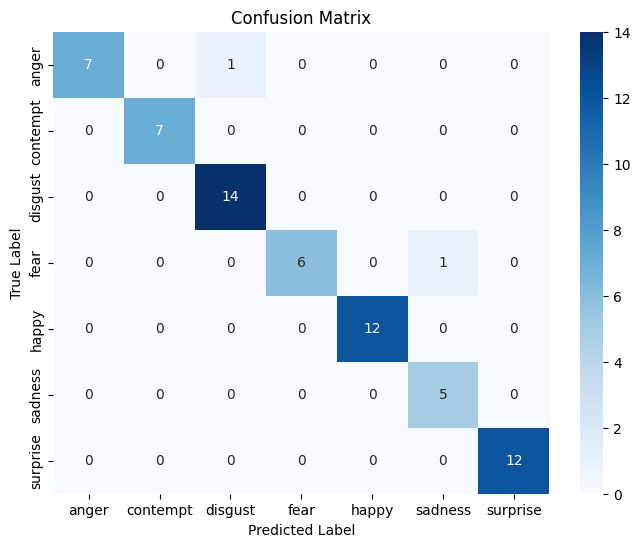

In [48]:
# -------------------------
# 9.3 Ma trận nhầm lẫn
# -------------------------
cm = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


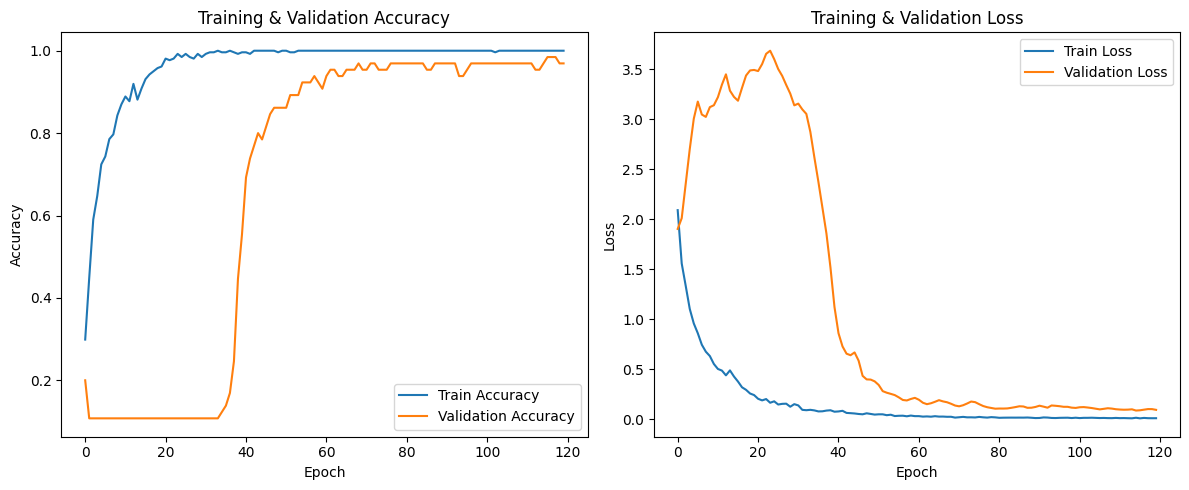

In [49]:
# -------------------------
# 9.4 Learning Curve (Độ chính xác & Độ mất mát)
# -------------------------
plt.figure(figsize=(12, 5))

# Độ chính xác
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Độ mất mát
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [50]:
# =========================
# 10. LƯU MÔ HÌNH CUỐI CÙNG
# =========================
final_model_path = '/content/drive/MyDrive/FER_CNN_LSTM/model_final_cnn_lstm.h5'
model.save(final_model_path)
print(f" Mô hình đã được lưu tại: {final_model_path}")


 Mô hình đã được lưu tại: /content/drive/MyDrive/FER_CNN_LSTM/model_final_cnn_lstm.h5
